In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, History
from sklearn.metrics import r2_score
from PrepareDataset import PrepareDatasetTimeDistributed

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('dataset/dataset.csv', header=0)

In [3]:
dataset = PrepareDatasetTimeDistributed(dataset=data, subsequences=3)
dataset = dataset.early_preparation()
dataset = dataset.set_rows_to_zeros()
dataset = dataset.split_power()
dataset = dataset.standard_scaled_dataset()

In [4]:
train_dataset = dataset.train()
val_dataset = dataset.val()
test_dataset = dataset.test()

In [5]:
tf.random.set_seed(0)
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=7, activation='relu'), input_shape=(None, 11, 1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=3)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))

In [6]:
model.compile(loss='mse', optimizer=Adam(0.001))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 5, 64)      512       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                        

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
model_checkpoint = ModelCheckpoint('CNNLSTMModelsubseq3.h5', verbose=0, save_best_only=True)
history = History()

In [9]:
model.fit(train_dataset[0], train_dataset[1], epochs=50, validation_data=(val_dataset[0], val_dataset[1]),
                                              callbacks=[early_stopping, model_checkpoint, history], batch_size=2, verbose=0)

In [10]:
loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

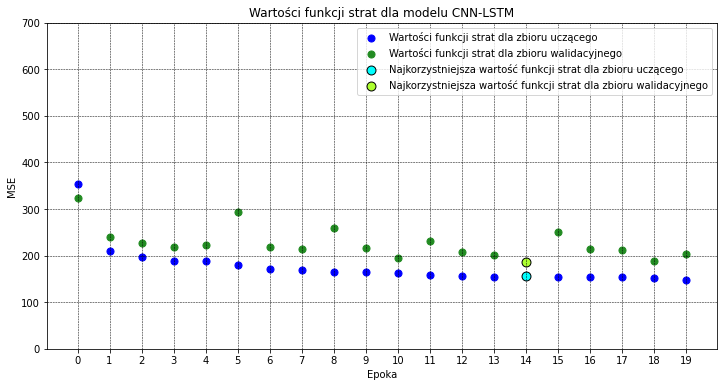

In [11]:
plt.scatter(range(len(loss)), loss, color='blue', label='Wartości funkcji strat dla zbioru uczącego', s=50)
plt.scatter(range(len(val_loss)), val_loss, color='forestgreen', label='Wartości funkcji strat dla zbioru walidacyjnego', s=50)
plt.scatter(np.argmin(val_loss), loss[np.argmin(val_loss)], color='cyan', edgecolors='black',
                                                            label='Najkorzystniejsza wartość funkcji strat dla zbioru uczącego', s=80)
plt.scatter(np.argmin(val_loss), np.min(val_loss), color='greenyellow', edgecolors='black',
                                                            label='Najkorzystniejsza wartość funkcji strat dla zbioru walidacyjnego', s=80)
fig = plt.gcf()
fig = fig.set_size_inches(12,6)
plt.xticks(range(len(loss)))
plt.yticks([i * 100 for i in range(0, 8)])
plt.grid(color='k', linewidth=0.5, linestyle='--')
plt.title('Wartości funkcji strat dla modelu CNN-LSTM')
plt.xlabel('Epoka')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.show()

In [12]:
model.load_weights('CNNLSTMModelsubseq3.h5')

In [13]:
predictions = model.predict(test_dataset[0], verbose=0)[:,0]

In [14]:
print(f'R^2 score: {round(r2_score(test_dataset[2], predictions), 3)}')
print(f'R score: {round(np.sqrt(r2_score(test_dataset[2], predictions)), 3)}')

R^2 score: 0.794
R score: 0.891


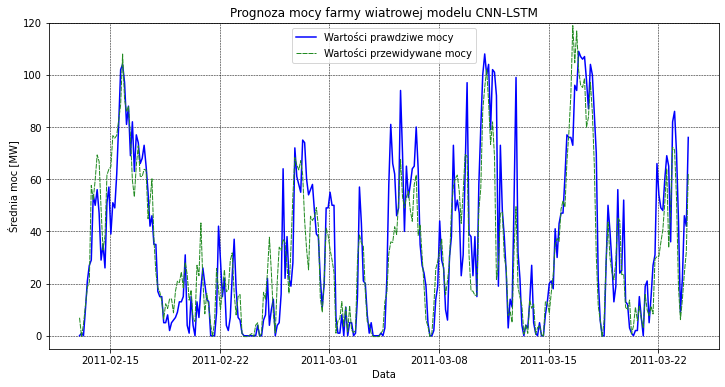

In [15]:
plt.plot(dataset.date_time[int(dataset.lenght * 0.9):][::dataset.subsequences], test_dataset[2], 
                                                                    color='blue', label='Wartości prawdziwe mocy', linewidth=1.5)
plt.plot(dataset.date_time[int(dataset.lenght * 0.9):][::dataset.subsequences], predictions, color='forestgreen',
                                                                    linestyle=(0,(5,1)), label='Wartości przewidywane mocy', linewidth=1)
fig = plt.gcf()
fig = fig.set_size_inches(12,6)
plt.ylim([-5, 120])
plt.ticklabel_format(axis='y', style='plain')
plt.grid(color='k', linewidth=0.5, linestyle='--')
plt.title('Prognoza mocy farmy wiatrowej modelu CNN-LSTM')
plt.xlabel('Data')
plt.ylabel('Średnia moc [MW]')
plt.legend(loc='best')
plt.show()

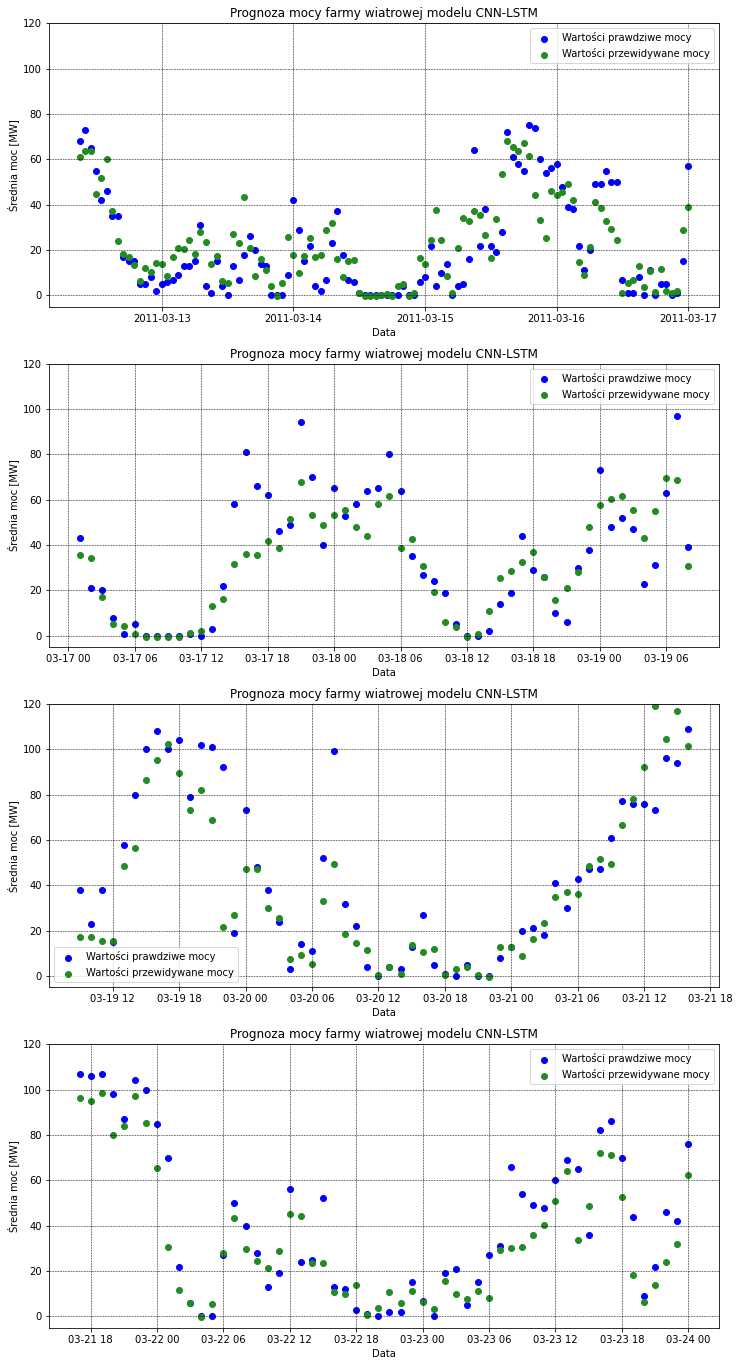

In [16]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(12,24))
ax3.scatter(dataset.date_time[-56:], test_dataset[2][-56:], color='blue', label='Wartości prawdziwe mocy')
ax3.scatter(dataset.date_time[-56:], predictions[-56:], color='forestgreen', label='Wartości przewidywane mocy')
ax3.set_ylim([-5, 120])
ax3.ticklabel_format(axis='y', style='plain')
ax3.grid(color='k', linewidth=0.5, linestyle='--')
ax3.set_title('Prognoza mocy farmy wiatrowej modelu CNN-LSTM')
ax3.set_xlabel('Data')
ax3.set_ylabel('Średnia moc [MW]')
ax3.legend(loc='best')

ax2.scatter(dataset.date_time[-112:-56], test_dataset[2][-112:-56], color='blue', label='Wartości prawdziwe mocy')
ax2.scatter(dataset.date_time[-112:-56], predictions[-112:-56], color='forestgreen', label='Wartości przewidywane mocy')
ax2.set_ylim([-5, 120])
ax2.ticklabel_format(axis='y', style='plain')
ax2.grid(color='k', linewidth=0.5, linestyle='--')
ax2.set_title('Prognoza mocy farmy wiatrowej modelu CNN-LSTM')
ax2.set_xlabel('Data')
ax2.set_ylabel('Średnia moc [MW]')
ax2.legend(loc='best')

ax1.scatter(dataset.date_time[-168:-112], test_dataset[2][-168:-112], color='blue', label='Wartości prawdziwe mocy')
ax1.scatter(dataset.date_time[-168:-112], predictions[-168:-112], color='forestgreen', label='Wartości przewidywane mocy')
ax1.set_ylim([-5, 120])
ax1.ticklabel_format(axis='y', style='plain')
ax1.grid(color='k', linewidth=0.5, linestyle='--')
ax1.set_title('Prognoza mocy farmy wiatrowej modelu CNN-LSTM')
ax1.set_xlabel('Data')
ax1.set_ylabel('Średnia moc [MW]')
ax1.legend(loc='best')

ax0.scatter(dataset.date_time[-280:-168], test_dataset[2][-280:-168], color='blue', label='Wartości prawdziwe mocy')
ax0.scatter(dataset.date_time[-280:-168], predictions[-280:-168], color='forestgreen', label='Wartości przewidywane mocy')
ax0.set_ylim([-5, 120])
ax0.ticklabel_format(axis='y', style='plain')
ax0.grid(color='k', linewidth=0.5, linestyle='--')
ax0.set_title('Prognoza mocy farmy wiatrowej modelu CNN-LSTM')
ax0.set_xlabel('Data')
ax0.set_ylabel('Średnia moc [MW]')
ax0.legend(loc='best')

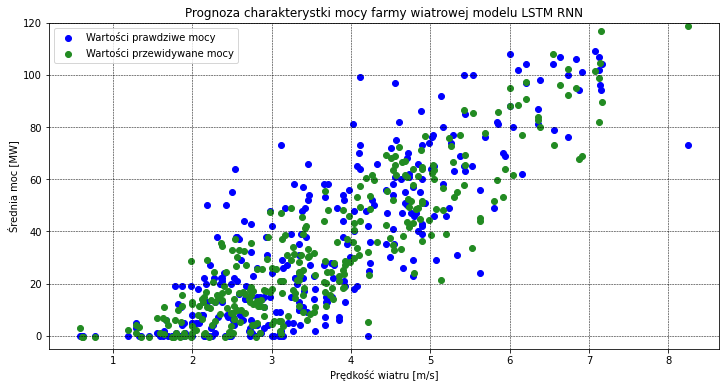

In [17]:
plt.scatter(dataset.wind_speed[int(dataset.lenght * 0.9):][::3], test_dataset[2], color='blue', label='Wartości prawdziwe mocy')
plt.scatter(dataset.wind_speed[int(dataset.lenght * 0.9):][::3], predictions, color='forestgreen', label='Wartości przewidywane mocy')
fig = plt.gcf()
fig = fig.set_size_inches(12,6)
plt.ylim([-5, 120])
plt.ticklabel_format(axis='y', style='plain')
plt.grid(color='k', linewidth=0.5, linestyle='--')
plt.title('Prognoza charakterystki mocy farmy wiatrowej modelu LSTM RNN')
plt.xlabel('Prędkość wiatru [m/s]')
plt.ylabel('Średnia moc [MW]')
plt.legend(loc='best')
plt.show()